In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [2]:
df_detailed   = pd.read_csv('../acc_rate_csvs/detailed.csv')
df_detailed['dataset'] = ' detailed \n N = 3730'
df_systematic = pd.read_csv('../acc_rate_csvs/systematic.csv')
df_systematic['dataset'] = ' systematic \n N = 3418'
df_epigenomic = pd.read_csv('../acc_rate_csvs/epigenomic.csv')
df_epigenomic['dataset'] = 'epigenomic \n N = 4913'
df = pd.concat([df_detailed, df_epigenomic, df_systematic, ])

avg_df = df.groupby(['dataset', 'method', 'feature engineer']).agg(
    median_acc=('acc', 'median'),
    q25_acc=('acc', lambda x: np.percentile(x, 25)),
    q75_acc=('acc', lambda x: np.percentile(x, 75))
).reset_index()

In [3]:
acc_compare_df = avg_df.copy()
acc_compare_df = acc_compare_df[acc_compare_df['method'] != 'BIC.1']
acc_compare_df['lower_bound'] = acc_compare_df['q25_acc']
acc_compare_df['upper_bound'] = acc_compare_df['q75_acc']

In [4]:
acc_compare_df['method'] = pd.Categorical(acc_compare_df['method'], 
                                          categories=['mmit.1', 'mmit.2', 'mmit.4', 'mmit.117', 'linear.1', 'linear.2', 'linear.4','linear.117', 'mlp.1', 'mlp.2', 'mlp.4', 'mlp.117'], ordered=True)

C:\Users\Tung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



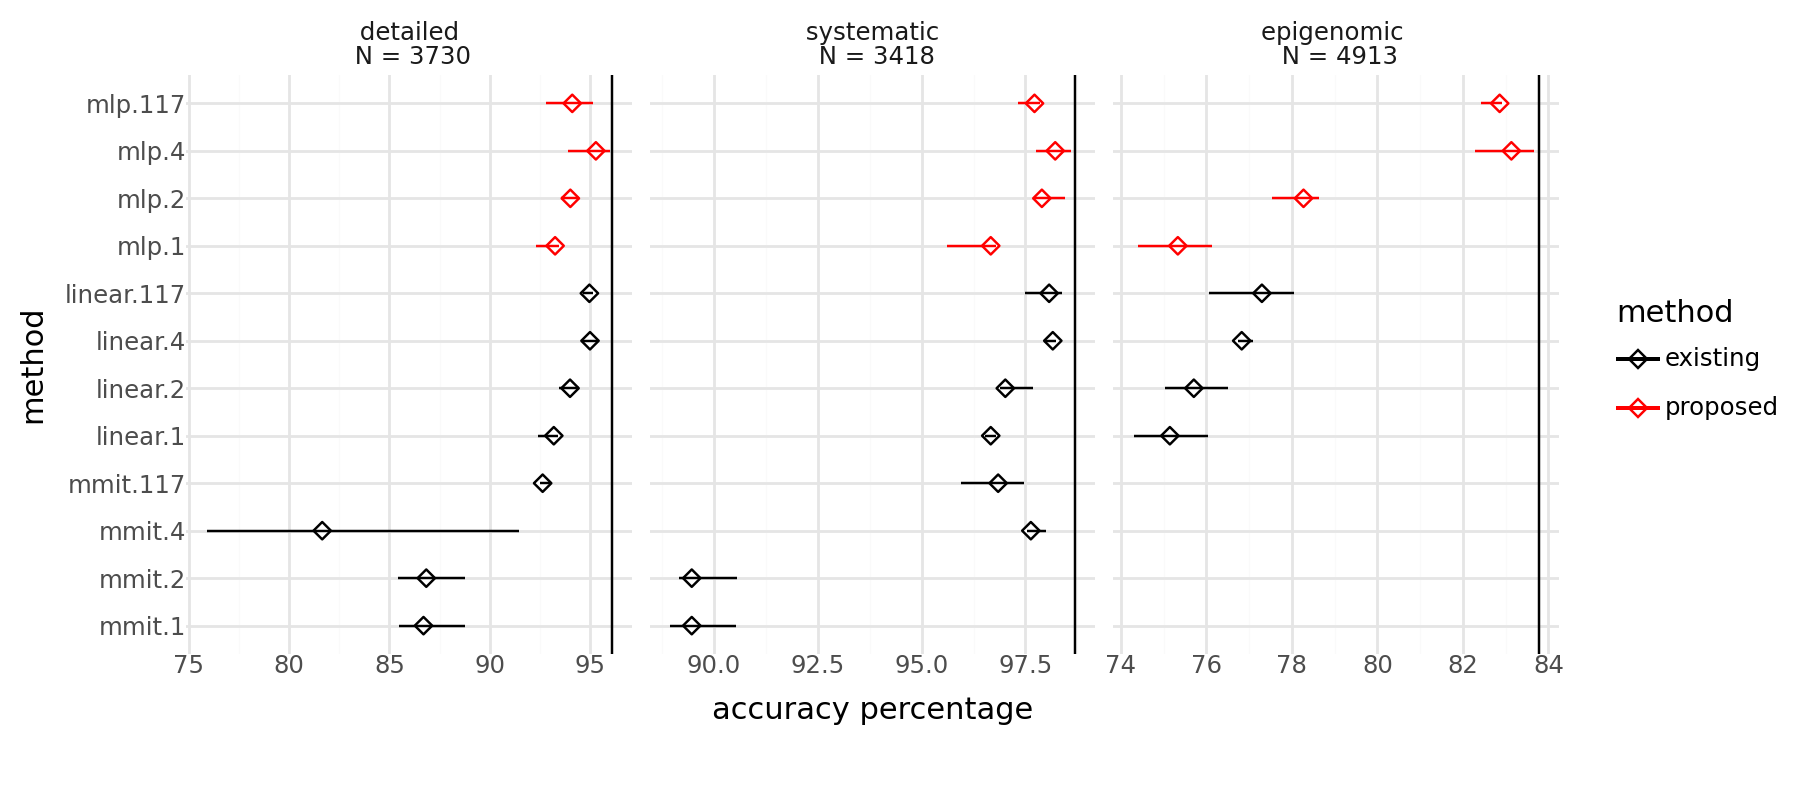

In [7]:
max_acc_per_dataset = acc_compare_df.groupby('dataset')['upper_bound'].max().reset_index()
max_acc_per_dataset.loc[:, 'upper_bound'] += 0.1

# Define colors for each method
method_colors = {
    'mmit.1':     'black',
    'linear.1':   'black',
    'mlp.1':      'red',
    'mmit.2':     'black',
    'linear.2':   'black',
    'mlp.2':      'red',
    'mmit.117':   'black',
    'linear.117': 'black',
    'mlp.117':    'red',
    'mmit.4':     'black',
    'linear.4':   'black',
    'mlp.4':      'red'
}

# Define colors for proposed and existing methods
method_colors = {
    'proposed': 'red',
    'existing': 'black'
}

# Create a new column indicating whether the method is proposed or existing
acc_compare_df['category'] = 'existing'
acc_compare_df.loc[acc_compare_df['method'].str.startswith('mlp'), 'category'] = 'proposed'

# Plot with color adjustments
plot_combined = (ggplot(acc_compare_df, aes(x='median_acc', y='method', color='category')) +
                 geom_point(shape="D", size=2, fill="white") +
                 geom_errorbarh(aes(xmin='lower_bound', xmax='upper_bound'), height=0.001) +
                 labs(x="accuracy percentage",
                      y="method") +
                 facet_wrap('~dataset', ncol=acc_compare_df['dataset'].nunique(), scales='free_x') +
                 theme_minimal() +
                 theme(aspect_ratio=1.3) +
                 geom_vline(data=max_acc_per_dataset, mapping=aes(xintercept='upper_bound'), color='black') + 
                 scale_color_manual(values=method_colors) +
                 theme(figure_size=(9, 4)) +
                 guides(color=guide_legend(title="method"))  # Manual legend
                 )

plot_combined.show()

In [6]:
plot_combined.save("acc_compare.pdf")
plot_combined.save("acc_compare.jpg")

C:\Users\Tung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotnine\ggplot.py:604: PlotnineWarning: Saving 9 x 4 in image.
C:\Users\Tung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotnine\ggplot.py:605: PlotnineWarning: Filename: acc_compare.pdf
C:\Users\Tung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



TypeError: cannot pickle 'generator' object